In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 1. 라이브러리 및 데이터 불러오기

- 본 프로젝트 수행을 위한 필수 라이브러리를 불러온다. 

In [ ]:
# 데이터 가공 
import numpy as np 
import pandas as pd 

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns 
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

- 이번에는 주어진 데이터를 불러온다. 
- 훈련데이터는 8,693개, 테스트 데이터는 4,277개로 구성이 되어 있음
- 독립변수 컬럼 갯수는 13개이며, 종속 변수는 1개로 구성되어 있음

In [ ]:
train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

train_data.shape, test_data.shape, sample_submission.shape

In [ ]:
train_data.head(10)

- Cabin을 Deck, Num, Side 3개로 분리
- 코드 출처 : https://www.kaggle.com/competitions/spaceship-titanic/discussion/309693

In [ ]:
train_data[['Deck', 'Num', 'Side']] = train_data['Cabin'].str.split('/', expand=True)
test_data[['Deck', 'Num', 'Side']] = test_data['Cabin'].str.split('/', expand=True)

- Age를 이용해 Adult인지 아닌지 구분
- 코드 출처 : https://www.kaggle.com/code/opamusora/top-10-notebook

In [ ]:
train_data['Adult']=True
train_data.loc[train_data['Age']<18, 'Adult']=False
test_data['Adult']=True
test_data.loc[test_data['Age']<18, 'Adult']=False

- PassengerId를 언더바를 경계로 Group으로 나눠줌
- 코드 출처 : https://www.kaggle.com/code/opamusora/top-10-notebook

In [ ]:
train_data['Group']=train_data['PassengerId'].apply(lambda x: x.split('_')[0])
test_data['Group']=test_data['PassengerId'].apply(lambda x: x.split('_')[0])

- Group과 Name을 이용해 PassengerID와 Name이 연관이 있는지 표시해주는 Relatives를 만듦
- 코드 출처 : https://www.kaggle.com/code/opamusora/top-10-notebook

In [ ]:
train_data['Name']=train_data['Name'].fillna(method='ffill')
test_data['Name']=test_data['Name'].fillna(method='ffill')

temp=pd.DataFrame(train_data.groupby(['Group'])['Name'])
d={}
for i in range(len(temp)):#len(temp)
    past_last_names=[]
    names=list(temp[1][i])
    rltvs=1
    for j in range(len(list(temp[1][i]))):#len(list(temp[1][i]))
        if(names[j].split(' ')[1] in past_last_names):
            rltvs+=1
        past_last_names.append(names[j].split(' ')[1])

    d[f"{temp[0][i]}"]=rltvs

train_data['Relatives']=train_data['Group'].map(d)


temp=pd.DataFrame(test_data.groupby(['Group'])['Name'])
d={}
for i in range(len(temp)):#len(temp)
    past_last_names=[]
    names=list(temp[1][i])
    rltvs=1
    for j in range(len(list(temp[1][i]))):#len(list(temp[1][i]))
        if(names[j].split(' ')[1] in past_last_names):
            rltvs+=1
        past_last_names.append(names[j].split(' ')[1])
    d[f"{temp[0][i]}"]=rltvs

test_data['Relatives']=test_data['Group'].map(d)

In [ ]:
train_data.head(20)

- train_data에 대해 살펴본다. 
- 먼저, 결측치가 있는 코드들이 있지만, 전체적으로 많은 편은 아님. 
- bool(2), float64(6), int(1), object(11)개로 구성이 되어 있음. 

In [ ]:
train_data.info()

- 테스트 데이터도 마찬가지로 비슷한 양상을 나타냄. 

In [ ]:
test_data.info()

- 예측해야 할 종속변수는 Transported 인 것으로 확인됨. 

In [ ]:
sample_submission.info()

- 데이터 컬럼 확인

# File and Data Field Descriptions

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
- sample_submission.csv - A submission file in the correct format.
    - PassengerId - Id for each passenger in the test set.
    - Transported - The target. For each passenger, predict either True or False.

# 파일 및 데이터 필드 설명
- train.csv - 승객의 약 3분의 2(~8700)에 대한 개인 기록으로, 훈련 데이터로 사용됩니다.
    - PassengerId - 각 승객의 고유 ID입니다. 각 ID는 ggg_pp 형식을 취하며, 여기서 ggg는 승객이 함께 여행하는 그룹을 나타내며, pp는 그룹 내 번호를 나타냅니다. 그룹의 사람들은 종종 가족 구성원이지만 항상 그렇지는 않다.
    - HomePlanet - 승객이 출발한 행성으로, 일반적으로 영구 거주지 행성입니다.
    - CryoSleep - 승객이 항해가 진행되는 동안 일시 정지 애니메이션으로 전환되도록 선택했는지 여부를 나타냅니다. 저온 수면 중인 승객들은 객실에 갇히게 된다.
    - Cabin - 승객이 머물고 있는 객실 번호입니다. 갑판/번호/측면 형식을 취합니다. 여기서 측면은 좌현에 P 또는 우현에 S가 될 수 있습니다.
    - Destination - 승객이 주차를 해제할 행성입니다.
    - Age - 승객의 연령입니다.
    - VIP - 승객이 여행 중 특별 VIP 서비스에 비용을 지불했는지 여부
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 우주선 타이타닉의 많은 고급 편의 시설 각각에서 청구한 금액입니다.
    - Name - 승객의 이름과 성.
    - Transported - 승객이 다른 차원으로 운송되었는지 여부. 예측하려는 대상 열입니다.
- test.csv - 테스트 데이터로 사용되는 나머지 승객의 1/3(~4300)에 대한 개인 기록. 작업은 이 세트의 승객에 대한 운송 값을 예측하는 것입니다.
- sample_submission.csv - 올바른 형식의 송신 파일.
    - PassengerId - 테스트 세트에 포함된 각 승객의 ID입니다.
    - Transported - 타겟. 각 승객에 대해 참 또는 거짓을 예측합니다.

- 대회주제
    + Transported Column 설명을 보면, 다른 차원으로 이동하기 위한, 각 승객의 탑승을 했는지 못했는지를 예측하는 문제이며, 평가지표는 정확도로 판정함.
- 분류 정확도(Classification Accuracy)의 설명은 [Classification Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)에서 확인할 수 있다. 

# Step 2. 탐색적 자료 분석 (EDA)
- 데이터 시각화
- 약간의 데이터 전처리

## 데이터 시각화를 위한 주요 함수 작성
- 훈련데이터의 구조는 다음과 같다. 
    + dtypes: bool(1), float64(6), object(10)
- 우선, 종속변수인 bool의 갯수에 대해 확인한다. 
- 갯수로 파악할 때는 비율은 큰 차이가 없는 것으로 확인했다. 즉, 데이터는 매우 균등하게 구성이 된 것이다. 
- Cabin에서 분리한 값인 Deck, Num, Side에 대해 파악했다.
- Age를 활용한 Adult에 대해 파악했다. 성인의 비율이 훨씬 높다.
- PassengerID를 이용한 Group과 2개 모두를 활용한 Relatives에 대해 파악했다.

In [ ]:
train_data['Transported'].value_counts()

In [ ]:
train_data['CryoSleep'].value_counts()

In [ ]:
train_data['Deck'].value_counts()

In [ ]:
train_data['Num'].value_counts()

In [ ]:
train_data['Side'].value_counts()

In [ ]:
train_data['Adult'].value_counts()

In [ ]:
train_data['Group'].value_counts()

In [ ]:
train_data['Relatives'].value_counts()

- bar 그래프 작성을 위한 함수

In [ ]:
def cnt_bar(data, col_name):
    df = data[col_name].value_counts()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = [str(item) for item in list(data[col_name].value_counts().index)]
    bars = sns.countplot(x=col_name, data=data, color='lightgray', alpha=0.85, zorder=2, ax=ax)
    
    for bar in bars.patches:
        fontweight = "normal"
        color = "k"
        height = np.round(bar.get_height(), 2)
        if bar.get_height() == data[col_name].value_counts().values[0]:
            fontweight="bold"
            color="orange"
            bar.set_facecolor(color)
        ax.text(bar.get_x() + bar.get_width()/2., height+100, height+1, ha = 'center', size=12, fontweight=fontweight, color=color)
    ax.set_title(f'Bar Graph of {col_name}', size = 16)
    ax.set_xlabel(col_name, size = 16)
    ax.set_ylabel("No. Passengers", size = 16)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(("outward", 20))
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(axis="y", which="major", color="lightgray")
    ax.grid(axis="y", which="minor", ls=":")
    
    plt.show()

- donut 그래프 작성을 위한 함수

In [ ]:
def cnt_donut(data, col_name):
    fig = go.Figure(data=[go.Pie(labels=data[col_name], hole=0.5)])
    fig.add_annotation(text=col_name,
                      x=0.5,y=0.5,showarrow=False,font_size=20,opacity=0.4)
    fig.update_layout(
        legend=dict(orientation='v',traceorder='reversed'),
        hoverlabel=dict(bgcolor='white'))
    fig.update_traces(textposition='outside', textinfo='percent+label')
    fig.show()

- 이제 함수를 적용해본다. 
    + Cabin, PassengerID, Num은 제외한다

In [ ]:
cnt_donut(train_data, "Destination")

In [ ]:
cnt_donut(train_data, "HomePlanet")

In [ ]:
cnt_bar(train_data, "CryoSleep")

In [ ]:
cnt_bar(train_data, "VIP")

In [ ]:
cnt_bar(train_data, "Transported")

In [ ]:
cnt_donut(train_data, "Deck")

In [ ]:
cnt_donut(train_data, "Side")

In [ ]:
cnt_donut(train_data, "Adult")

- 이번에는 Describe() 함수를 적용해본다. 

In [ ]:
train_data.describe()

In [ ]:
numeric_features = train_data.select_dtypes(include=[np.number])
numeric_features.columns

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 14)) # 그래프의 행과 열 지정 및, 이미지 사이즈 지정
data = train_data.copy()
# data[numeric_features.columns].columns[0:]
for i, col in enumerate(data[numeric_features.columns].columns[0:]): # 좌표 평면 지정
    # print(i, col)
    if i <= 2:
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[0,i]) # 1행 좌표 평면
    else: 
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[1,i-4]) # 5행 좌표 평면
fig.suptitle('My Box Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

- 위 시각화 결과물을 놓고 보면, RoomService, FoodCount, Spa, VRDeck, ShoppingMall은 수치가 아닌 것처럼 보임. 

In [ ]:
train_data['RoomService'].value_counts()

In [ ]:
train_data['FoodCourt'].value_counts()

In [ ]:
train_data['Spa'].value_counts()

- 실제 컬럼명에서 말하는 것도 다음과 같음. 
    + RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- 즉, 위 데이터는 연속형 데이터라고 보기에는 비연속형 수치 데이터인 것을 확인함. 

# Step 3. 데이터 전처리
- Feature Engineering
- ML 모형을 돌리기 위해 표준화 등 / 원핫-인코딩
- 파생변수 (도출 변수)

## 불필요한 변수 제거 
- 모형에 쓰지 않을 변수들을 제거한다. 
    + PassengerId, Name, Age, Carbin
- PassengerID와 Name은 Group과 Relatives를 만들었기 때문에 제거한다.
- Age는 Adult로 구분했기 때문에 제거한다.
- Cabin은 값을 분리했기 때문에 제거한다.

In [ ]:
remove_cols = ['PassengerId', 'Age', 'Name', 'Cabin']
PassengerId = test_data['PassengerId']

print("Before:", train_data.shape, test_data.shape)
train_data = train_data.drop(remove_cols, axis=1)
test_data = test_data.drop(remove_cols, axis=1)

print("After:", train_data.shape, test_data.shape)

## 결측치 
- 결측치 데이터를 추가하도록 한다. 결측치를 추가하기 위해 SimpleImputer 클래스를 사용하였다. 
- train_data의 결측치 패턴을 파악한 후, train_data 및 test_data 결과에도 적용한다. 
    + 주의 : 반드시 이렇게 해야 한다. (Data Leakage 방지)

In [ ]:
train_data.isnull().sum()

In [ ]:
test_data.isnull().sum()

- 결측치를 처리하기 위해 가장 쉬운 방법은 sklearn.impute 내에서의 SimpleImputer 클래스를 활용하는 것이다. 
    + https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [ ]:
from sklearn.impute import SimpleImputer

imputer_cols = ["FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", "Num", "Group", "Relatives"]
STRATEGY = 'median'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train_data:\n", train_data.isnull().sum())
print("---")
print("test_data:\n", test_data.isnull().sum())

- 이번에는 문자열 데이터를 추가한다. 

In [ ]:
imputer_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side", "Adult"]
STRATEGY = 'most_frequent'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train_data:\n", train_data.isnull().sum())
print("---")
print("test_data:\n", test_data.isnull().sum())

- 결측치가 사라진 것을 확인할 수 있다. 

## Categorical Feature Encoding
- 머신러닝 알고리즘은 수식으로 구성이 되어 있기 때문에 문자열의 경우 인코딩으로 변환을 주어야 한다. 
- OneHot Encoding 방식을 사용한다

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side", "Adult"]

transformer = make_column_transformer(
    (OneHotEncoder(), categorical_cols),
    remainder='passthrough')

train_transformed = transformer.fit_transform(train_data[categorical_cols])
train_transformed_df = pd.DataFrame(train_transformed, columns=transformer.get_feature_names_out())
train_data = pd.concat([train_data, train_transformed_df], axis = 1)
train_data = train_data.drop(categorical_cols, axis = 1)

test_transformed = transformer.fit_transform(test_data[categorical_cols])
test_transformed_df = pd.DataFrame(test_transformed, columns=transformer.get_feature_names_out())
test_data = pd.concat([test_data, test_transformed_df], axis = 1)
test_data = test_data.drop(categorical_cols, axis = 1)

In [ ]:
train_data.info()

In [ ]:
test_data.info()

# Step 4. 머신러닝 모형 개발

- 독립변수와 종속변수를 구분해야 한다. 

In [ ]:
X_cols = test_data.columns
X = train_data[X_cols].to_numpy()
y = train_data['Transported'].to_numpy()

- 이번에는 훈련데이터와 검증데이터를 분리한다. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Model Selection 
- Ref. https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide
- 그리드 서치를 적용함. 

## 모형 옵션 선택
- 아래와 같은 모형을 정의한다. 

In [ ]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "LGBM" : LGBMClassifier(random_state=0)
}

- 그리드 서치를 위한 옵션을 선택한다. 

In [ ]:
# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}


boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
    "LGBM" : boosted_grid
}

- 불러온 모형과 그리드 서치를 각각 개별적으로 정의하는 코드를 작성한다. 
- 해당 결과는 모두 데이터프레임에 담도록 한다. 

In [ ]:
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

import time

i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_val, y_val)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')

    i+=1

- 4개의 모형에 대한 모형 개발 속도 및 정확도 평가지표를 확인한다. 

In [ ]:
# Show results
valid_scores

- 그리드 서치를 통해서 얻어낸 지표 중 가장 좋은 파라미터를 찾는다. 

In [ ]:
clf_best_params

- 가장 좋은 모형을 적용한다.
- 정확도 평가지표가 낮은 LogisticRegression과 KNN은 제외한다

In [ ]:
# Classifiers
best_classifiers = {
    "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=0),
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0)
}

- 이번에는 10겹 교차검증을 실시한다. 

In [ ]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(test_data))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 5-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(test_data)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

# Step 5. 모형 평가

- 10회 교차검증을 했을 때 RandomForest보다 LightGBM이 약간의 우세에 있었다.
- 혼동행렬 (Confusion Matrix) 설명
    + 모델의 성능을 평가할때 사용되는 지표
    + 정확도(Accuracy), 정밀도(Precision), 재현도(Recall) 3가지가 있음
#### 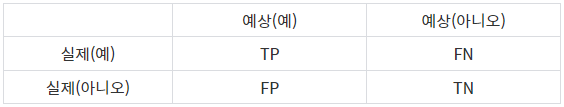
- 표 설명
    + TP(True Positive) : 참긍정 - 참이라고 예측을 했는데 실제로 참인 경우
    + TN(True Negative) : 참부정 - 참이라고 예측을 했는데 실제로 거짓인 경우
    + FP(False Positive) : 거짓긍정 - 거짓이라고 예측을 했는데 실제로 참인 경우
    + FN(False Negative) : 거짓부정 - 거짓이라고 예측을 했는데 실제로 거짓인 경우
    
- 정확도 : 모델이 입력된 데이터에 대해 얼마나 정확하게 예측하는지를 나타낸다.
    + (TP + FN) / (전체 데이터)
    + 모델이 Transported의 참 거짓 구분을 얼마나 정확하게 했는지 나타냄
- 정밀도 : 모델의 예측값이 얼마나 정확하게 예측됐는가를 나타내는 지표. 즉, 예라고 예측했을 때의 정답률
    + (TP) / (TP + FP)
    + 모델이 Transported에서 T라고 표시한것들 중 실제로 T인 비율
- 재현도 : 실제값 중에서 모델이 검출한 실제값의 비율을 나타내는 지표
    + (TP) / (TP + FN)
    + 실제로 Transported 값이 T인 부분에서 모델이 T라고 구분한 비율
- F1 점수 : 정밀도도 중요하고 재현율도 중요한데 둘 중 무엇을 쓸지 고민되는 경우 쓰는 지표. 정밀도와 재현율을 조화평균내서 하나의 수치로 나타냄.
    + (2 x 재현율 x 정밀도) / (재현율 + 정밀도)

# Step 6. 제출

In [ ]:
# Round predictions to nearest integer
preds=np.round(preds).astype(bool)
sample_submission['Transported'] = preds
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()